# Time-Series Analysis

## Environment set up
Change the working directory to be able to work with the source-code.

In [1]:
import os
from pathlib import Path

WORKING_DIRECTORY = Path.cwd().parents[0]
os.chdir(WORKING_DIRECTORY)

## Imports

In [2]:
from src.read import read_nasa_vibration_files_in_directory
from src.signals import get_resolution
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import polars as pl

## Inputs

The inputs have been obtained from the NASA bearings documentation.

The following cell displays the data path for each test and the name of their columns:

In [3]:
DATA_INPUTS_PER_TEST = {
    '1st_test': {'data_path': 'data/nasa_ims_bearing_dataset/1st_test',
                  'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4',
                                   'channel_5', 'channel_6', 'channel_7', 'channel_8'],
                 'faulty_channels': ['channel_5', 'channel_6', 'channel_7', 'channel_8']},
    '2nd_test': {'data_path': 'data/nasa_ims_bearing_dataset/2nd_test',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_1']},
    '3rd_test': {'data_path': 'data/nasa_ims_bearing_dataset/3rd_test/4th_test/txt',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_3']}
          }

As each test has a different set up of sensors or channels per bearing, the following cell describes them:

In [4]:
BEARING_CHANNEL_MAPPING = {
    '1st_test': {'bearing_1': ['channel_1', 'channel_2'],
                 'bearing_2': ['channel_3', 'channel_4'],
                 'bearing_3': ['channel_5', 'channel_6'],
                 'bearing_4': ['channel_7', 'channel_8']},
    '2nd_test': {'bearing_1': ['channel_1'],
                 'bearing_2': ['channel_2'],
                 'bearing_3': ['channel_3'],
                 'bearing_4': ['channel_4']},
    '3rd_test': {'bearing_1': ['channel_1'],
                 'bearing_2': ['channel_2'],
                 'bearing_3': ['channel_3'],
                 'bearing_4': ['channel_4']}                 
}

Next, the faulty bearings are defined per test:

In [5]:
FAULTY_BEARINGS_PER_TEST = {
    '1st_test': {'bearing_3': 'bearing_inner_race',
                 'bearing_4': 'bearing_roller'
                 },
    '2nd_test': {'bearing_1': 'bearing_outer_race'},
    '3rd_test': {'bearing_3': 'bearing_outer_race'}
}

As final inputs, the following parameters are needed to read properly the vibration signals. In addition, an acceptable sensor range is defined to avoid faulty channel signals:

In [6]:
SAMPLING_RATE_IN_HERTZ = 20000
MEASUREMENT_DURATION_IN_SECONDS = 1
ACCEPTABLE_SENSOR_RANGE = 0.01

## Read the data

In [7]:
complete_data_path_per_test = {}

for test, inputs_per_test in DATA_INPUTS_PER_TEST.items():
    for key, values in inputs_per_test.items():
        data_path = inputs_per_test['data_path']
        complete_path = WORKING_DIRECTORY.joinpath(data_path)
        complete_data_path_per_test[test] = complete_path


In [8]:
signal_resolution = get_resolution(sampling_frequency=SAMPLING_RATE_IN_HERTZ)

df_list_per_test = {}
for test, file_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    column_names = DATA_INPUTS_PER_TEST[test]['column_names']
    df_list = read_nasa_vibration_files_in_directory(files_path=file_path, sensors=column_names,
                                                     signal_resolution=signal_resolution,
                                                     acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE)
    df_list_per_test[test] = df_list

2026-01-17 08:56:40.094 | INFO     | __main__:<module>:5 - test: 1st_test
2026-01-17 08:56:43.378 | INFO     | src.read:read_nasa_vibration_files_in_directory:102 - 0 files were discarded.
2026-01-17 08:56:43.379 | INFO     | src.read:read_nasa_vibration_files_in_directory:103 - 1092 files were read successfully.
2026-01-17 08:56:43.380 | INFO     | __main__:<module>:5 - test: 2nd_test
2026-01-17 08:56:44.306 | WARNING  | src.read:read_nasa_vibration_files_in_directory:88 - All sensors in file 2004.02.19.06.22.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2026-01-17 08:56:44.877 | WARNING  | src.read:read_nasa_vibration_files_in_directory:88 - All sensors in file 2004.02.19.06.12.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2026-01-17 08:56:45.007 | INFO     | src.read:read_nasa_vibration_files_in_directory:102 - 2 files were discarded.
2026-01-17 08:56:45.007 | INFO     | src.read:read_nasa_vibration_files_in_d

## Time-series plots

The following plots show the first and last available measurements to see see how the data differences for a bearing while changes from healthy to faulty:

In [9]:
ALPHA = 0.5

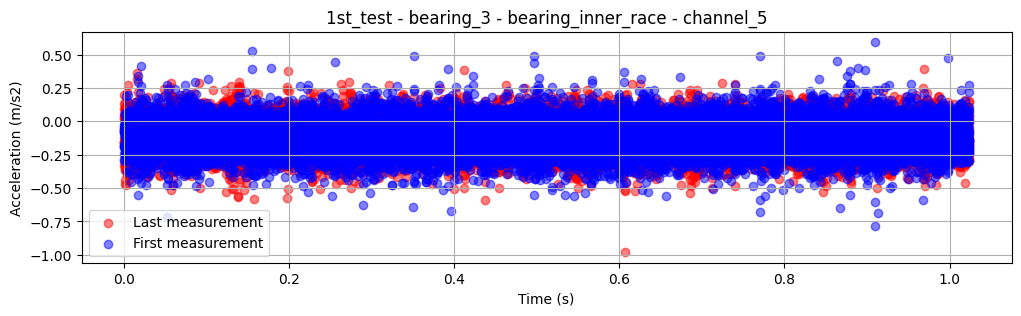

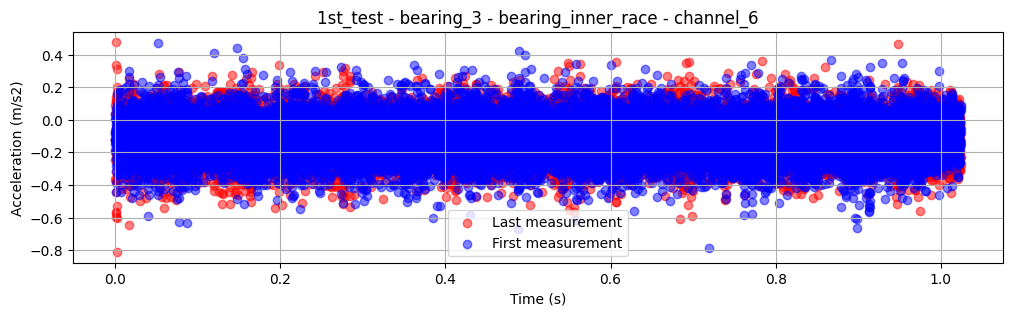

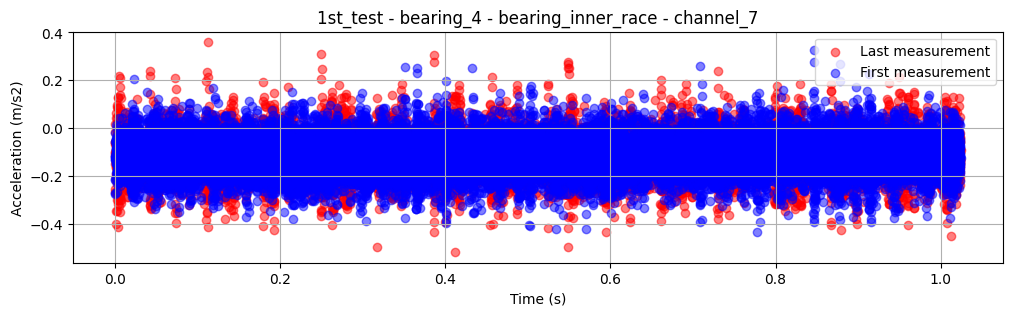

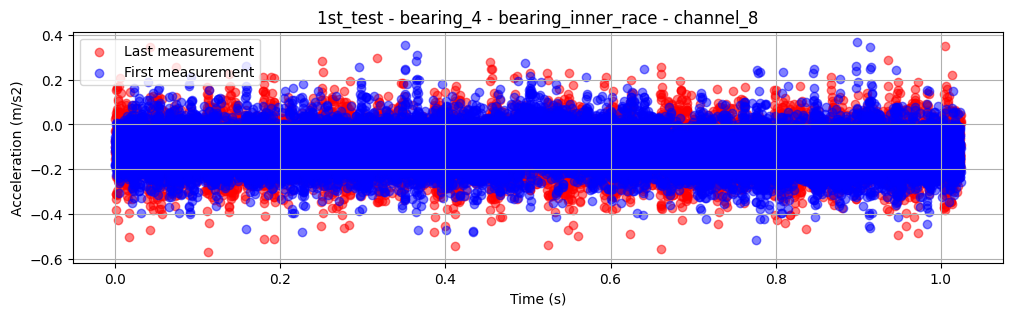

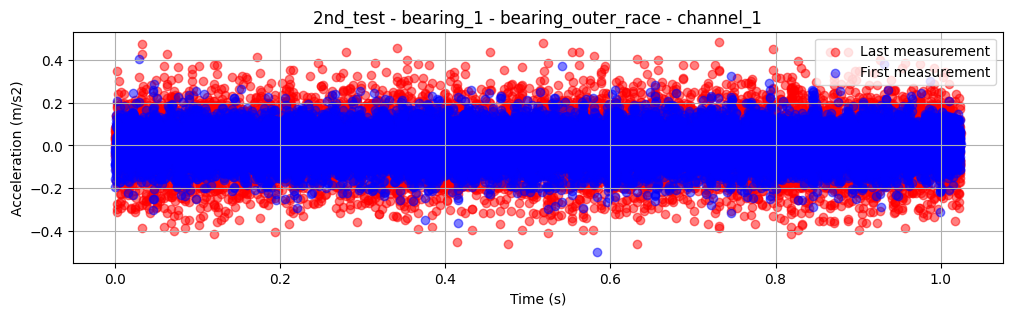

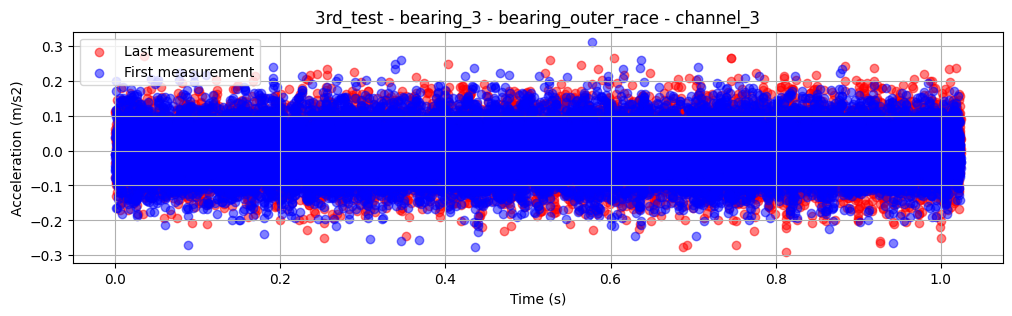

In [23]:
for test, df_list in df_list_per_test.items():
    faulty_bearings = list(FAULTY_BEARINGS_PER_TEST[test].keys())
    fault = list(FAULTY_BEARINGS_PER_TEST[test].values())[0]
    for faulty_bearing in faulty_bearings:
        channels = BEARING_CHANNEL_MAPPING[test][faulty_bearing]
        for channel in channels:                 
            plt.figure(figsize=(12, 3))
            plt.scatter(df_list[-1]['measurement_time_in_seconds'], df_list[-1][channel], label='Last measurement', color='red', alpha=ALPHA)
            plt.scatter(df_list[0]['measurement_time_in_seconds'], df_list[0][channel], label='First measurement', color='blue', alpha=ALPHA)
            plt.legend()
            plt.grid()
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (m/s2)')
            plt.title(f'{test} - {faulty_bearing} - {fault} - {channel}');

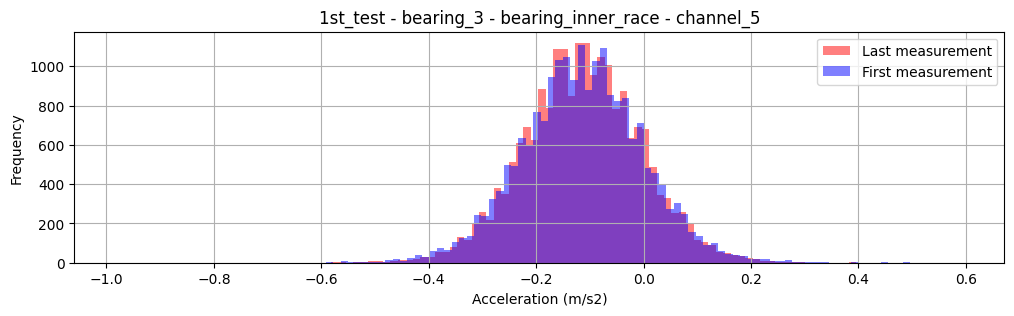

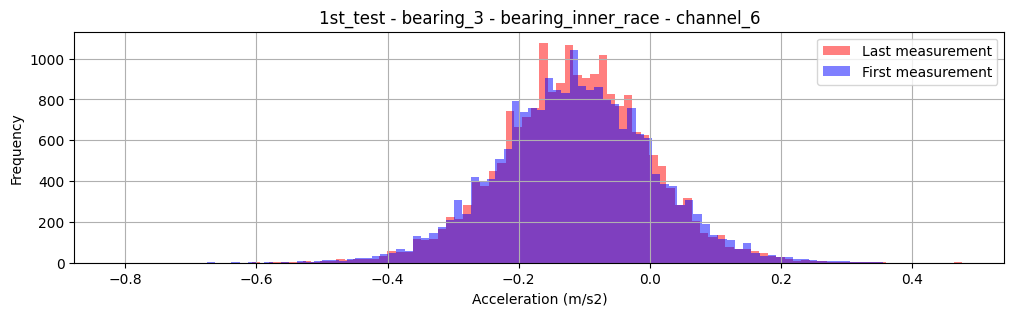

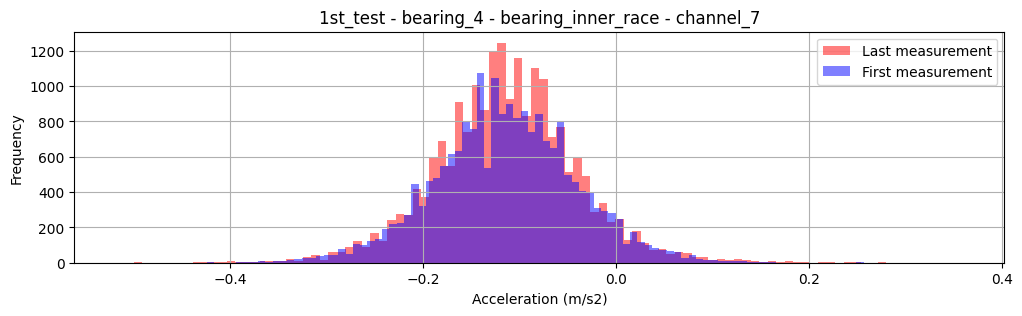

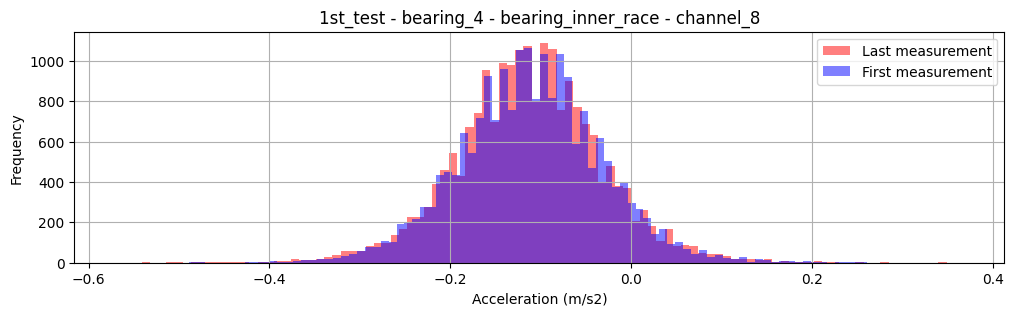

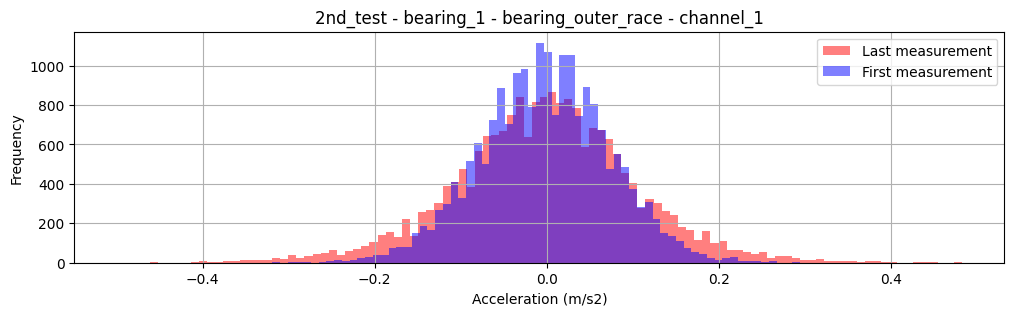

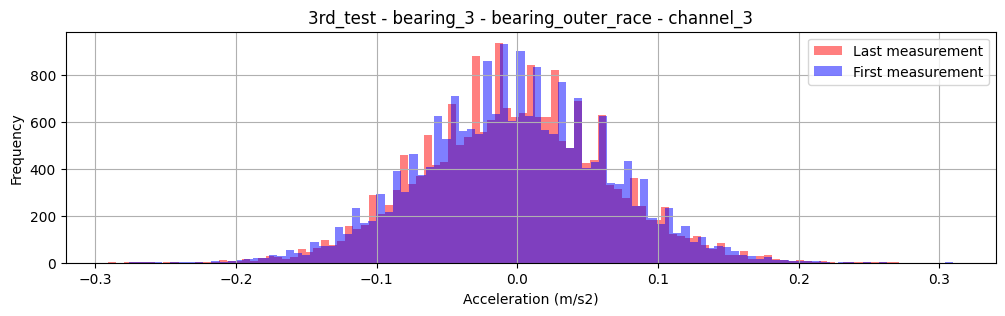

In [24]:
BINS = 100

for test, df_list in df_list_per_test.items():
    faulty_bearings = list(FAULTY_BEARINGS_PER_TEST[test].keys())
    fault = list(FAULTY_BEARINGS_PER_TEST[test].values())[0]
    for faulty_bearing in faulty_bearings:
        channels = BEARING_CHANNEL_MAPPING[test][faulty_bearing]
        for channel in channels:                 
            plt.figure(figsize=(12, 3))
            plt.hist(df_list[-1][channel], label='Last measurement', color='red', alpha=ALPHA, bins=BINS)
            plt.hist(df_list[0][channel], label='First measurement', color='blue', alpha=ALPHA, bins=BINS)
            plt.legend()
            plt.grid()
            plt.xlabel('Acceleration (m/s2)')
            plt.ylabel('Frequency')
            plt.title(f'{test} - {faulty_bearing} - {fault} - {channel}');

Let's check all the channels in histograms to see if there is any other finding:

In [ ]:
BINS = 100

for test, df_list in df_list_per_test.items():
    faulty_bearings = list(FAULTY_BEARINGS_PER_TEST[test].keys())
    fault = list(FAULTY_BEARINGS_PER_TEST[test].values())[0]
    for faulty_bearing in faulty_bearings:
        channels = BEARING_CHANNEL_MAPPING[test][faulty_bearing]
        for channel in channels:                 
            plt.figure(figsize=(12, 3))
            plt.hist(df_list[-1][channel], label='Last measurement', color='red', alpha=ALPHA, bins=BINS)
            plt.hist(df_list[0][channel], label='First measurement', color='blue', alpha=ALPHA, bins=BINS)
            plt.legend()
            plt.grid()
            plt.xlabel('Acceleration (m/s2)')
            plt.ylabel('Frequency')
            plt.title(f'{test} - {faulty_bearing} - {fault} - {channel}');

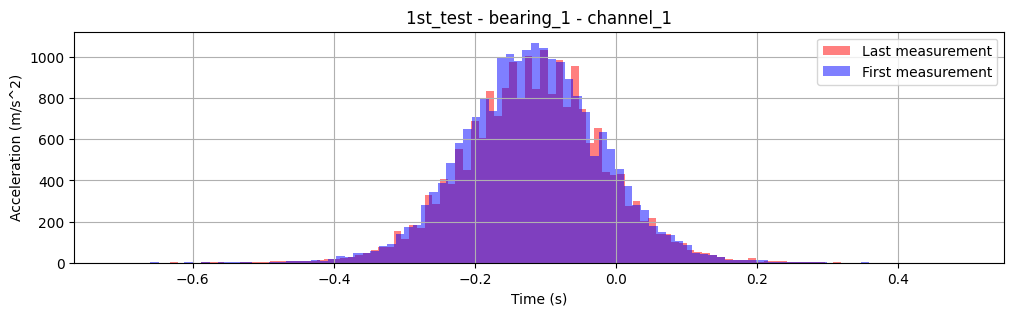

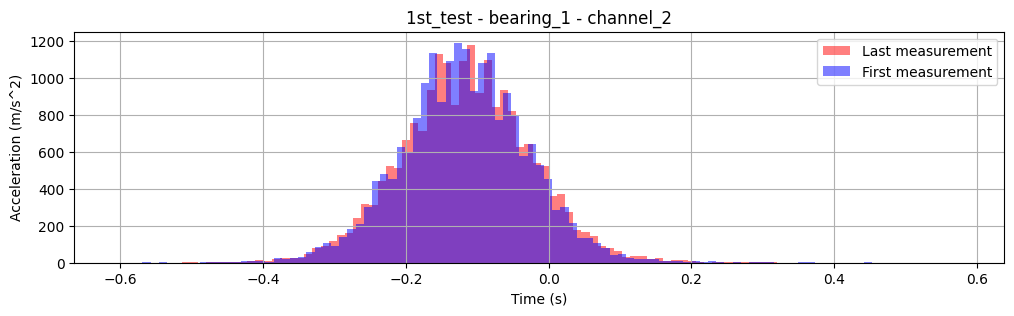

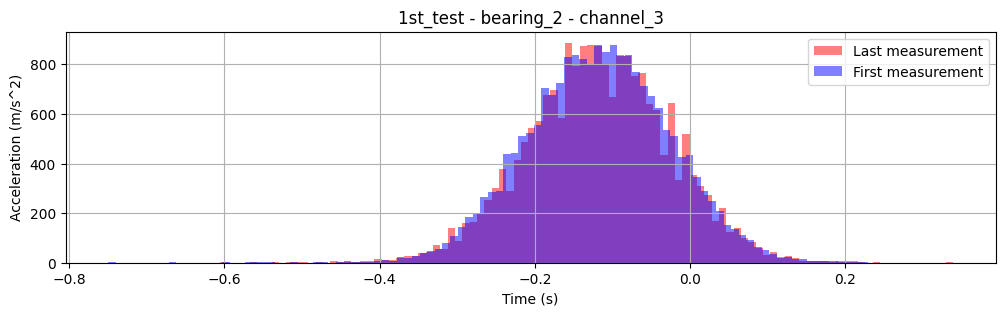

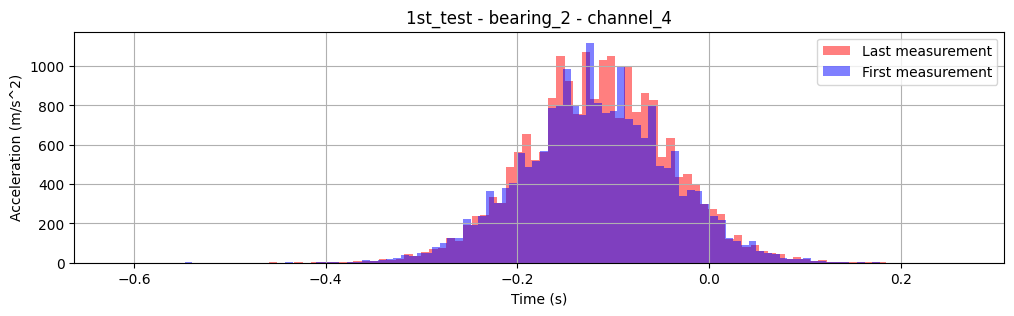

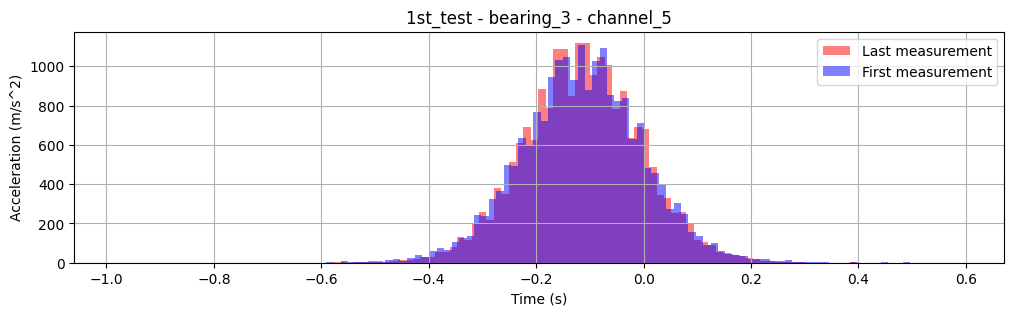

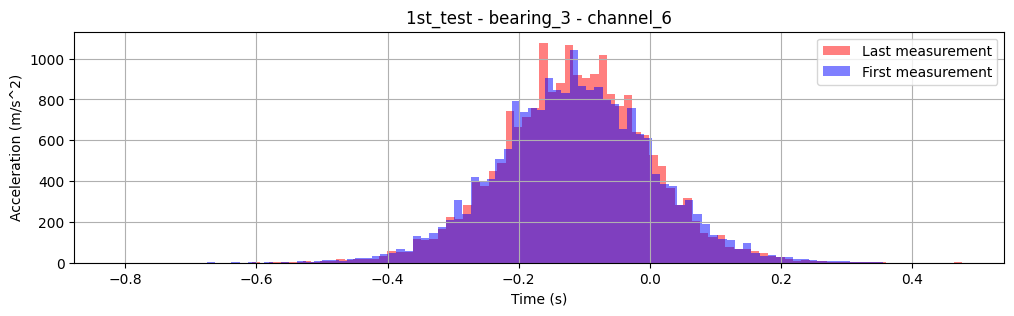

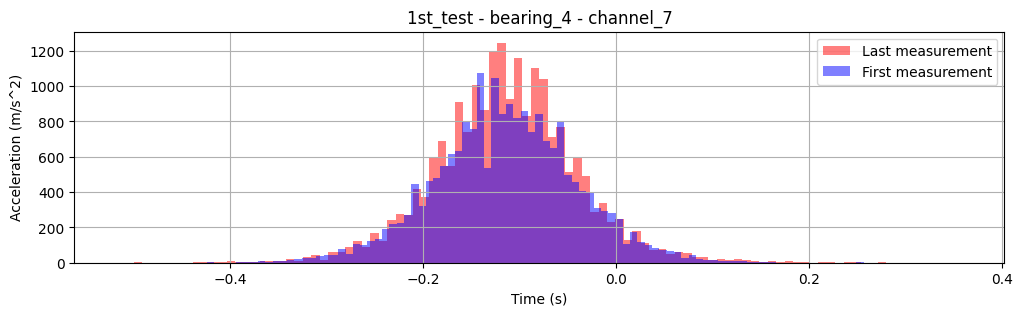

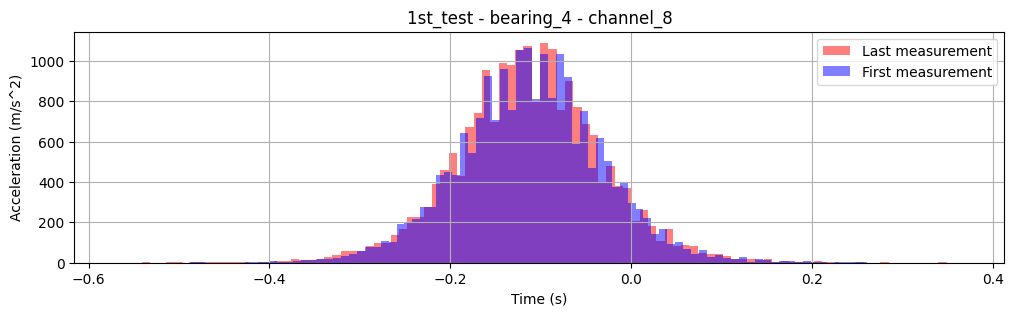

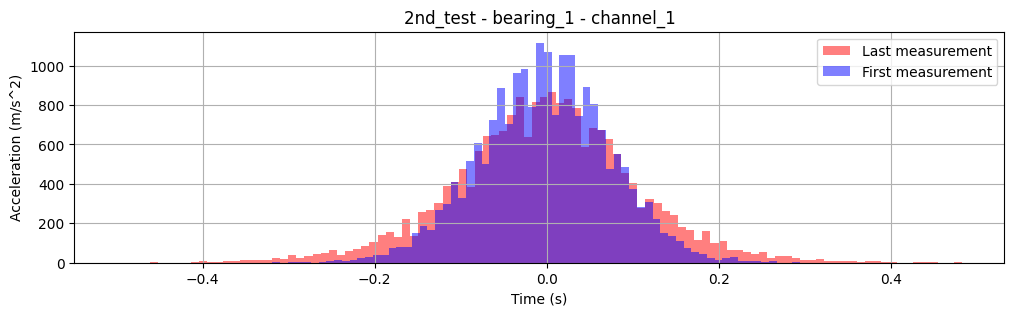

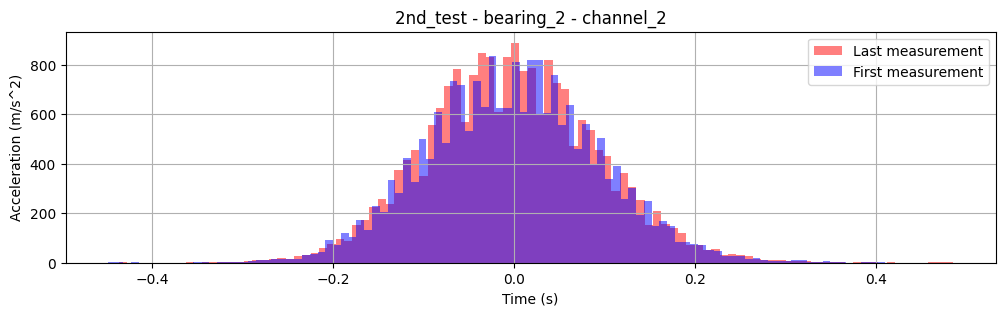

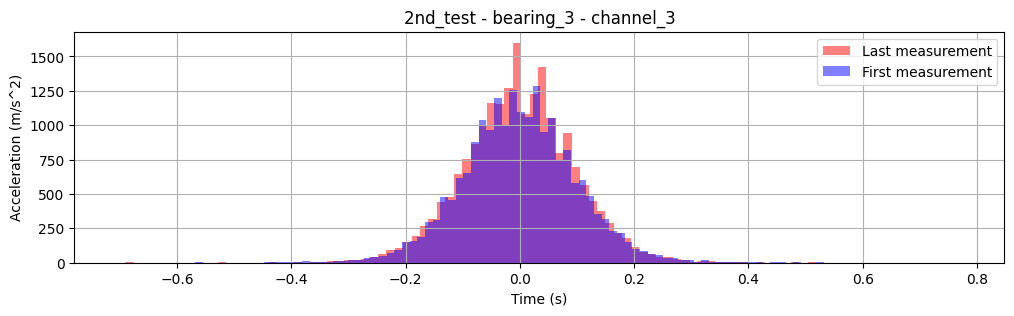

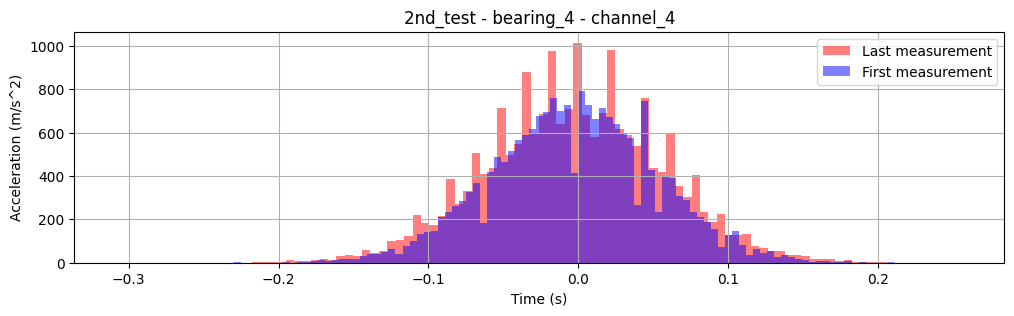

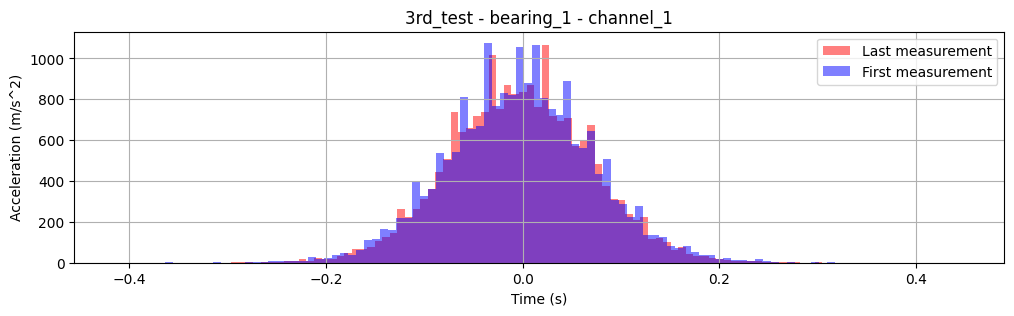

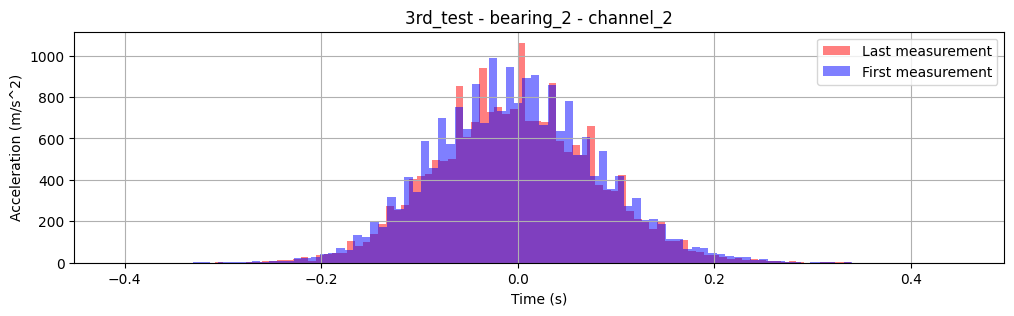

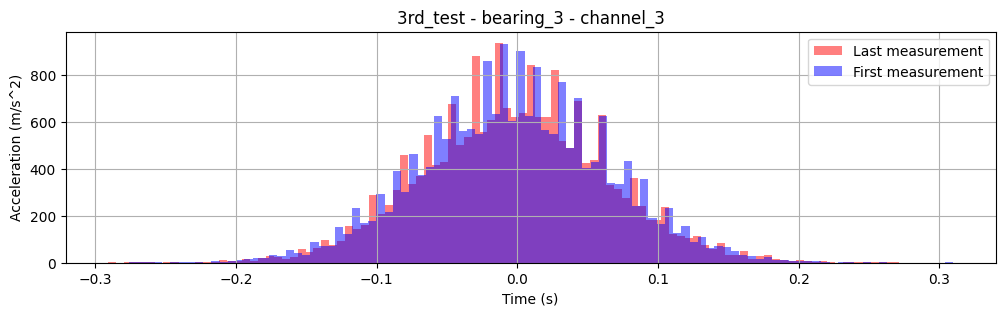

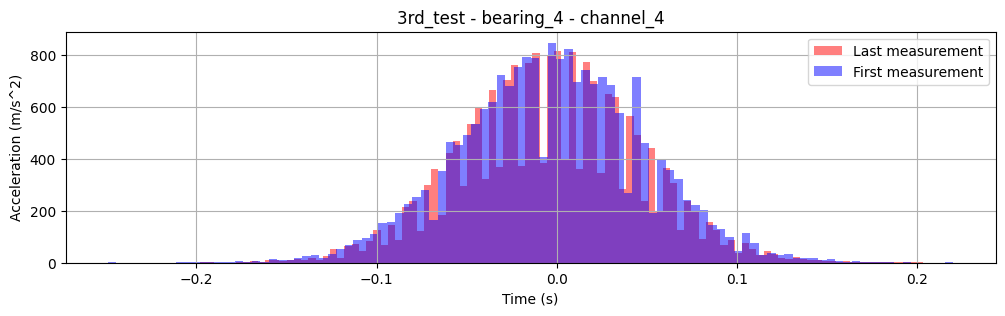

In [29]:
for test, df_list in df_list_per_test.items():
    for bearings, channels in BEARING_CHANNEL_MAPPING[test].items():
        for channel in channels:
           plt.figure(figsize=(12, 3))
           plt.hist(df_list[-1][channel], label='Last measurement', color='red', alpha=ALPHA, bins=BINS)
           plt.hist(df_list[0][channel], label='First measurement', color='blue', alpha=ALPHA, bins=BINS)
           plt.legend()
           plt.grid()
           plt.xlabel('Time (s)')
           plt.ylabel('Acceleration (m/s^2)')
           plt.title(f'{test} - {bearings} - {channel}');

As a first conclusion, the 2nd test is the only one that shows a difference. The last measurement for channel 1, which corresponds to bearing 1, has a wider histogram than the first measurement. Therefore, the vibration amplitude has increased from the first measurement to the last measurement. That increase in vibration explains the bearing failue, since faulty bearings tend to have greater vibration amplitudes than before when they were healthy.

The 1st test and 3rd test do not show any clear evidence for the moment about a failure in the bearing considering the previous plots, because there is no considerable change in the vibration level between the first and the last measurement.

# Aggregation

Different aggregation functions are used to better understand the evolution of the failure using the time-series data:

In [13]:
AGGREGATION_FUNCTIONS = {
        "max": lambda c: pl.col(c).max(),
        "min": lambda c: pl.col(c).min(),
        "mean": lambda c: pl.col(c).mean(),
    }

In [14]:
aggregated_df_per_test = {}

for test, df_list in df_list_per_test.items():
    print(f"test: {test}")
    df = pl.concat(df_list, how='vertical')
    faulty_channels = DATA_INPUTS_PER_TEST[test]["faulty_channels"]
    exprs = [
        fn(col).alias(f"{stat}_{col}")
        for col in faulty_channels
        for stat, fn in AGGREGATION_FUNCTIONS.items()
    ]

    aggregated_df = (
        df
        .group_by("file_name")
        .agg(exprs)
    )

    # Convert file_name into datetime
    aggregated_df = aggregated_df.with_columns(
        pl.col("file_name").str.strptime(
            pl.Datetime,
            format="%Y.%m.%d.%H.%M.%S"
        ).alias("date_time")
    )

    aggregated_df_per_test[test] = aggregated_df

test: 1st_test
test: 2nd_test
test: 3rd_test


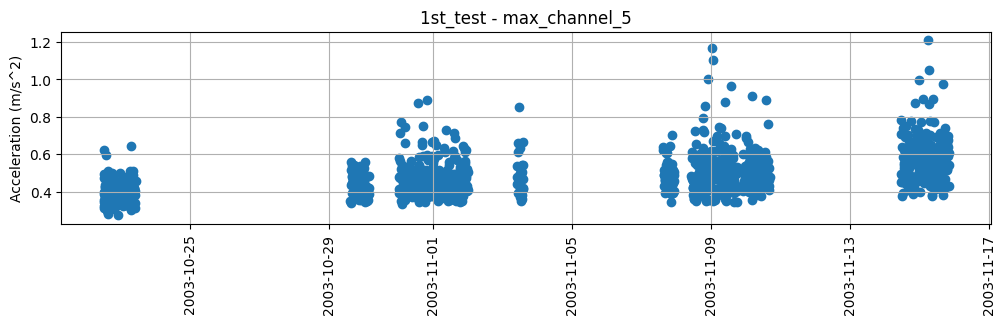

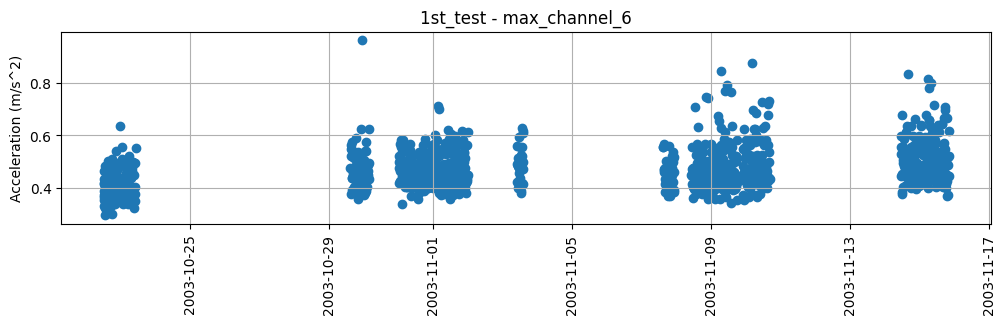

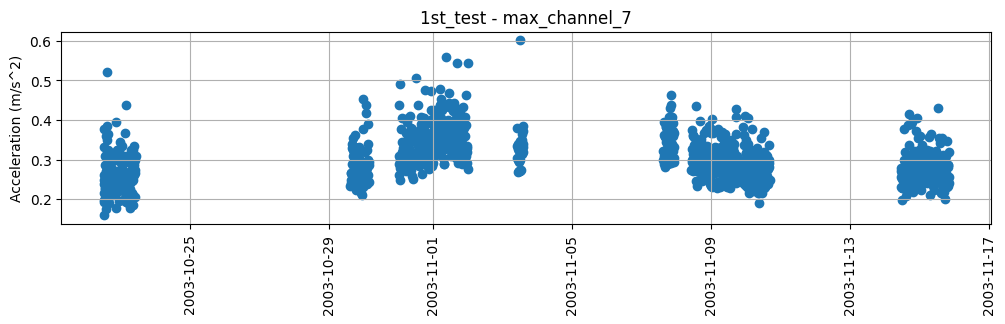

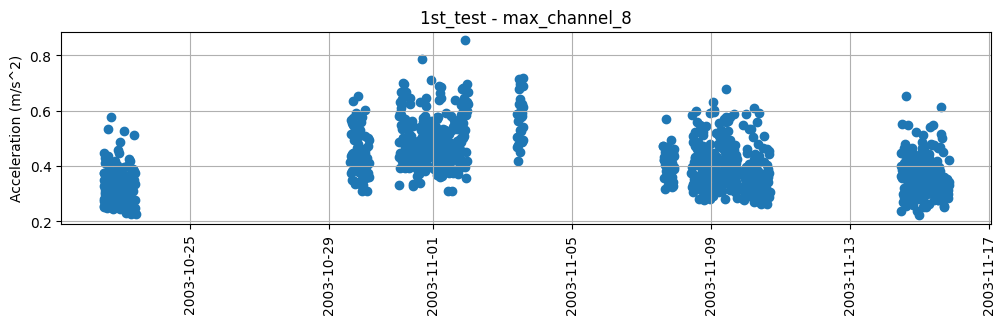

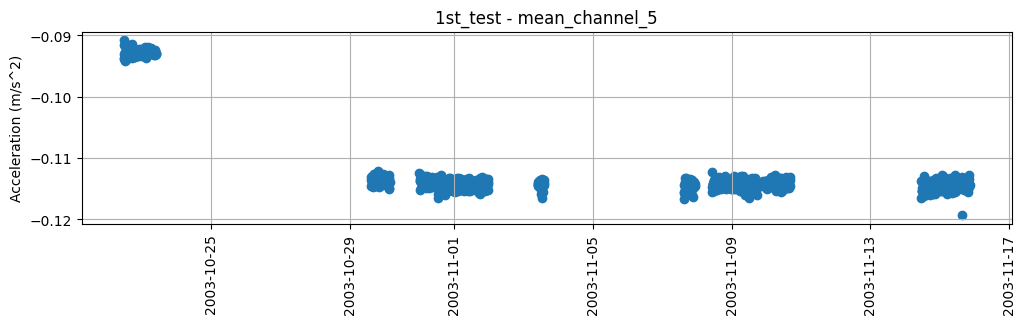

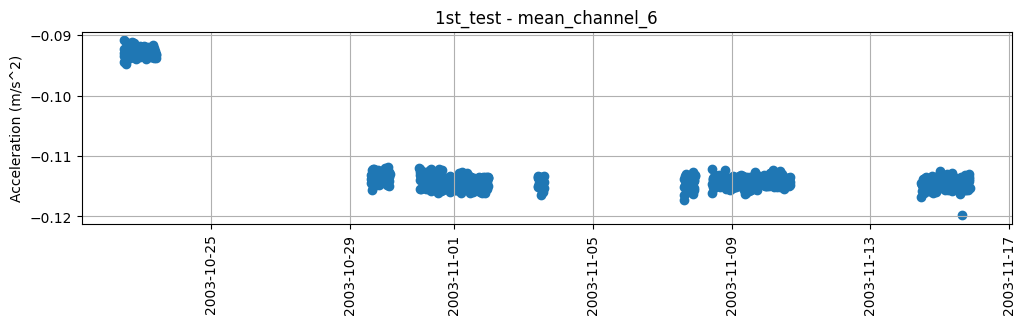

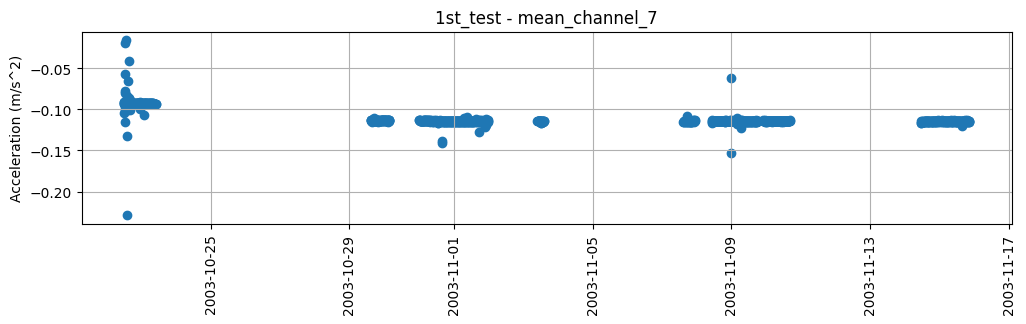

Error in callback <function flush_figures at 0x7bc93017e820> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [15]:
for test, aggregated_df in aggregated_df_per_test.items():
    plot_columns = np.sort(np.array([i for i in aggregated_df.columns if 'channel' in i]))

    for plot_column in plot_columns:
        plt.figure(figsize=(12, 2.5))
        plt.scatter(aggregated_df['date_time'], aggregated_df[plot_column])
        plt.ylabel('Acceleration (m/s^2)')
        plt.xticks(rotation=90)
        plt.title(f'{test} - {plot_column}')
        plt.grid()